# Identifying Deforestation Drivers
## INF367A Project

<p style="text-align:right"><b>Created by:</b> Halfdan Hesthammer, Lasse Holt and Tobias Husebø</p>

&nbsp;

---

&nbsp;

### Imports and initialization:

#### Imports used:

In [1]:
## Machine Learning Libraries: 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

## Math imports: 
import numpy as np
import matplotlib.pyplot as plt
import random

## Plotting / Image processing imports: 
import json
import os
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
from tqdm import tqdm

&nbsp;

#### Initialization:

In [2]:
# Initializing seed, datatype and main computing unit:
torch.manual_seed(69)
torch.set_default_dtype(torch.float32)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
data_path = "data"

Using device: mps


&nbsp;

&nbsp;

---

&nbsp;

### Data Exploration:

#### Printing Image Statistics Utilizing `rasterio` Package:

##### Defining a .tif image opening function:

In [3]:
def open_tif_image(file_path):
    '''Open a specific tif image and return file and array'''
    src_file  = rasterio.open(file_path)
    src_array = src_file.read()
    return src_file, src_array

&nbsp;

##### Opening and printing statistics:

In [4]:
def analyze_tif_image(file_path):
    src_file, src_array = open_tif_image(file_path)

    print(f"Image shape (bands, height, width):\n - {src_array.shape}\n")

    print(f"Image bands (index, dtype, nodataval, NaN count):")
    for i, dtype, band_array in zip(
        src_file.indexes, src_file.dtypes, src_array
    ):
        nan_count = np.isnan(band_array).sum()
        print(f"Band {i}: dtype = {dtype}, NaN count = {nan_count}")

file_path = data_path + "/train_images/train_0.tif"

analyze_tif_image(file_path)

Image shape (bands, height, width):
 - (12, 1024, 1024)

Image bands (index, dtype, nodataval, NaN count):
Band 1: dtype = float64, NaN count = 9429
Band 2: dtype = float64, NaN count = 9429
Band 3: dtype = float64, NaN count = 9429
Band 4: dtype = float64, NaN count = 9429
Band 5: dtype = float64, NaN count = 9429
Band 6: dtype = float64, NaN count = 9429
Band 7: dtype = float64, NaN count = 9429
Band 8: dtype = float64, NaN count = 9429
Band 9: dtype = float64, NaN count = 9429
Band 10: dtype = float64, NaN count = 9429
Band 11: dtype = float64, NaN count = 9429
Band 12: dtype = float64, NaN count = 9429


&nbsp;

#### Opening Images utilizing `rasterio` package:

##### Plotting every individual band:

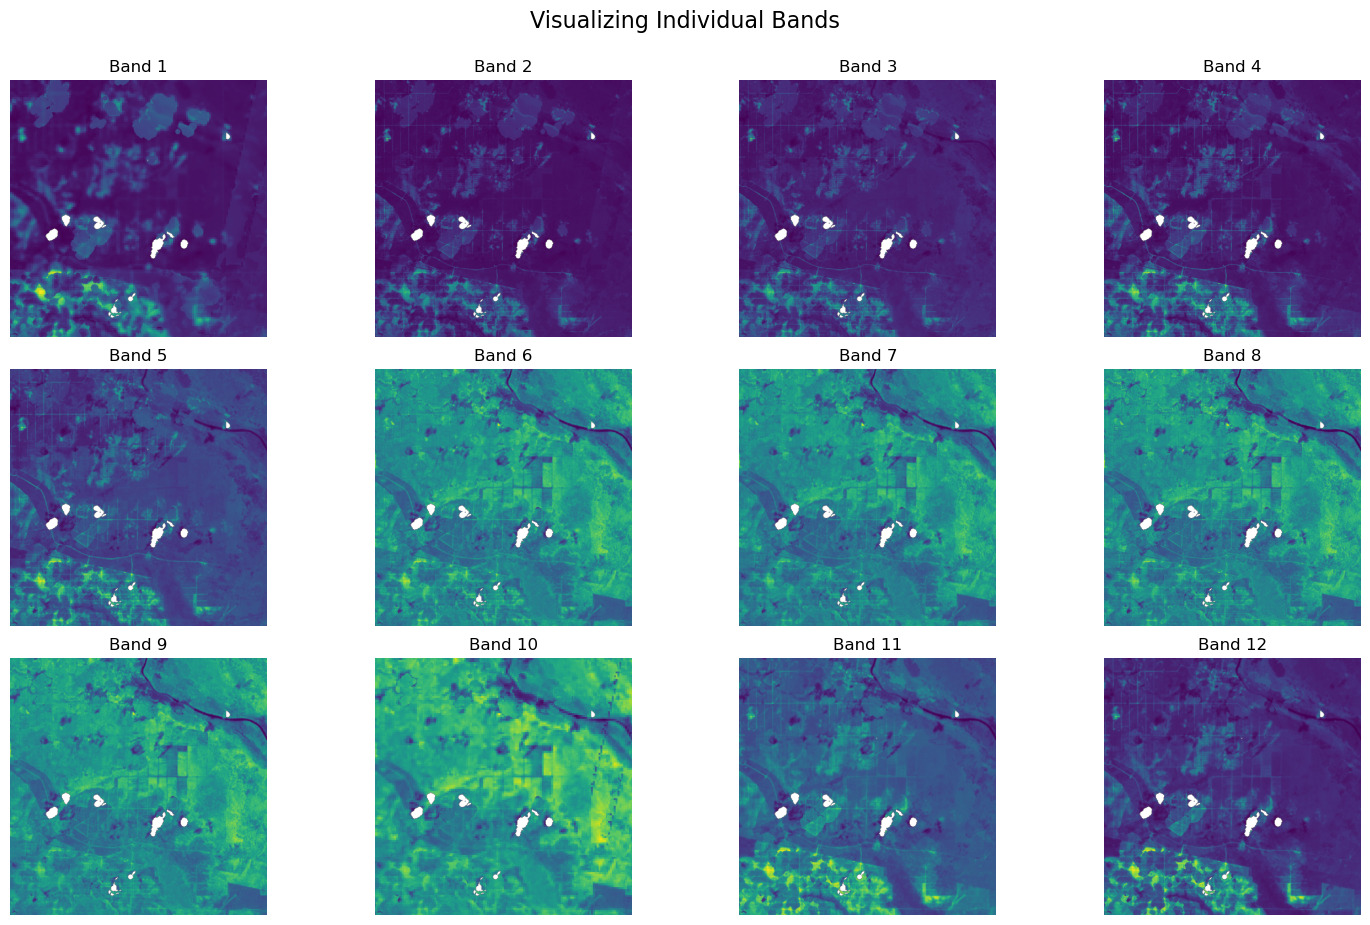

In [5]:
# Create a figure with a 3x4 grid
def visualize_bands(path):
    _, src_array = open_tif_image(path)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Adjust figsize for spacing
    fig.suptitle("Visualizing Individual Bands", fontsize=16, y=0.92)  # Main header

    # Loop through bands and plot each one
    for i, ax in enumerate(axes.flat):
        ax.imshow(src_array[i])      
        ax.set_title(f"Band {i + 1}") 
        ax.axis('off')                 

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  
    plt.show()

visualize_bands(file_path)

&nbsp; 

##### Calculating the overall mean and standard deviation per band:

In [6]:
def calculate_overall_mean_std(image_dir):

    band_sums = None
    band_squared_sums = None
    num_pixels = None  

    for filename in os.listdir(image_dir):
        if filename.endswith('.tif'):
            file_path = os.path.join(image_dir, filename)
            with rasterio.open(file_path) as src:
                image_array = src.read() 
            
            mask = np.isnan(image_array) # Find nan_values to replace
            image_array[mask] = 0  
            
            if band_sums is None:
                band_sums = np.zeros(image_array.shape[0], dtype=np.float32)
                band_squared_sums = np.zeros(image_array.shape[0], dtype=np.float32)
                num_pixels = np.zeros(image_array.shape[0], dtype=np.float32)

            band_sums += np.sum(image_array, axis=(1, 2))
            band_squared_sums += np.sum(image_array**2, axis=(1, 2))
            num_pixels += image_array.shape[1] * image_array.shape[2] 

    overall_means = band_sums / num_pixels
    overall_stds = np.sqrt(band_squared_sums / num_pixels - overall_means**2)

    return overall_means, overall_stds


image_directory = data_path + "/train_images"
overall_means, overall_stds = calculate_overall_mean_std(image_directory)

for i, (mean, std) in enumerate(zip(overall_means, overall_stds), start=1):
    print(f"Band {i}: Overall Mean = {mean:.4f}, Overall Std = {std:.4f}")

Band 1: Overall Mean = 285.8191, Overall Std = 216.4498
Band 2: Overall Mean = 327.2209, Overall Std = 269.8881
Band 3: Overall Mean = 552.9304, Overall Std = 309.9285
Band 4: Overall Mean = 392.1574, Overall Std = 397.4567
Band 5: Overall Mean = 914.3139, Overall Std = 400.2207
Band 6: Overall Mean = 2346.1182, Overall Std = 630.3277
Band 7: Overall Mean = 2884.4836, Overall Std = 789.7993
Band 8: Overall Mean = 2886.4426, Overall Std = 810.4764
Band 9: Overall Mean = 3176.7502, Overall Std = 852.9021
Band 10: Overall Mean = 3156.9351, Overall Std = 807.5939
Band 11: Overall Mean = 1727.1945, Overall Std = 631.7798
Band 12: Overall Mean = 848.5731, Overall Std = 502.6685


&nbsp;

#### Looking at masks:

##### Defining a .json opening and segementation retrieving function:

In [7]:
def open_json(file_path=data_path + "/train_annotations.json"):
    with open(f"{file_path}") as f:
        annotations = json.load(f)
    return annotations

def return_image_annotations(image_num, file_path=data_path + "/train_annotations.json"):
    annotations = open_json(file_path)
    return annotations["images"][image_num]

&nbsp;

##### Utilizing functions segmentation retrieval functions:

In [8]:
# Loading training annotations for image 0:
annotations_image_0 = return_image_annotations(0)

header = "Training Annotation Statistics"
print(f"{header} \n" + f"{'-' * len(header)}")

subtitle_1 = "Keys and Values in Training Annotations:"
print(f"\n{(len(subtitle_1)+4)*'#'}" + f"\n# {subtitle_1} #\n" + f"{(len(subtitle_1)+4)*'#'}\n")
for key, value in annotations_image_0.items():
    value = str(value)
    if len(value) > 25:
        print(f"- Key: {key}")
        print(f"- Value: {value[:25]}... \n")
    else:
        print(f"- Key: {key}")
        print(f"- Value: {value:25s} \n")

subtitle_2 = "Segmentations with Class names:"
print(f"\n{(len(subtitle_2)+4)*'#'}" + f"\n# {subtitle_2} #\n" + f"{(len(subtitle_2)+4)*'#'}\n")
for annotation in annotations_image_0.get("annotations", []):
    class_name = annotation["class"]
    segmentation = annotation["segmentation"]
    print(f"- Class: {class_name}")
    print(f"- Segmentation: {segmentation} \n")

Training Annotation Statistics 
------------------------------

############################################
# Keys and Values in Training Annotations: #
############################################

- Key: file_name
- Value: train_0.tif               

- Key: annotations
- Value: [{'class': 'plantation', ... 

- Key: startend_date_composite
- Value: 2019/01/01_2020/12/31     


###################################
# Segmentations with Class names: #
###################################

- Class: plantation
- Segmentation: [0.0, 449.0, 9.0, 454.0, 18.0, 461.0, 26.0, 468.0, 33.0, 475.0, 40.0, 477.0, 50.0, 485.0, 59.0, 497.0, 70.0, 502.0, 78.0, 513.0, 82.0, 523.0, 91.0, 536.0, 97.0, 546.0, 98.0, 556.0, 102.0, 558.0, 111.0, 578.0, 122.0, 603.0, 132.0, 627.0, 133.0, 635.0, 113.0, 641.0, 86.0, 642.0, 86.0, 642.0, 71.0, 643.0, 69.0, 654.0, 65.0, 665.0, 58.0, 674.0, 51.0, 681.0, 56.0, 694.0, 57.0, 700.0, 80.0, 695.0, 83.0, 700.0, 88.0, 702.0, 88.0, 703.0, 102.0, 699.0, 113.0, 695.0, 122.0, 696.

&nbsp;

#### Looking at class counts:

##### Defining a `count_classes()` function to count the occurence of classes:

In [9]:
def count_classes():
    count = {}
    area = {}
    total_area_all = 0

    for i in range(176):
        image_anno = return_image_annotations(i)
        total_area_image = 1024 * 1024  # Full image area
        total_area_foreground = 0

        for annotation in image_anno.get("annotations", []):
            class_name = annotation["class"]
            polygon = np.array(annotation["segmentation"], dtype=np.int32).reshape(-1, 2)
            poly_area = cv2.contourArea(polygon)
            total_area_foreground += poly_area

            if class_name in count:
                count[class_name] += 1
                area[class_name] += poly_area
            else:
                count[class_name] = 1
                area[class_name] = poly_area

        background_area = total_area_image - total_area_foreground
        if "background" in area:
            area["background"] += background_area
        else:
            area["background"] = background_area

        total_area_all += total_area_image

    return count, area

&nbsp;

##### Utilizing `count_classes()` function to count the occurence of classes:

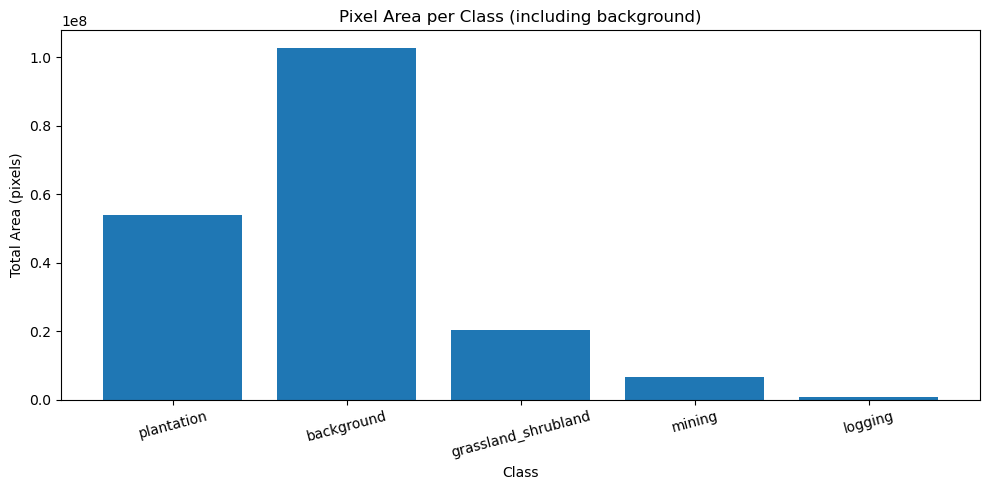

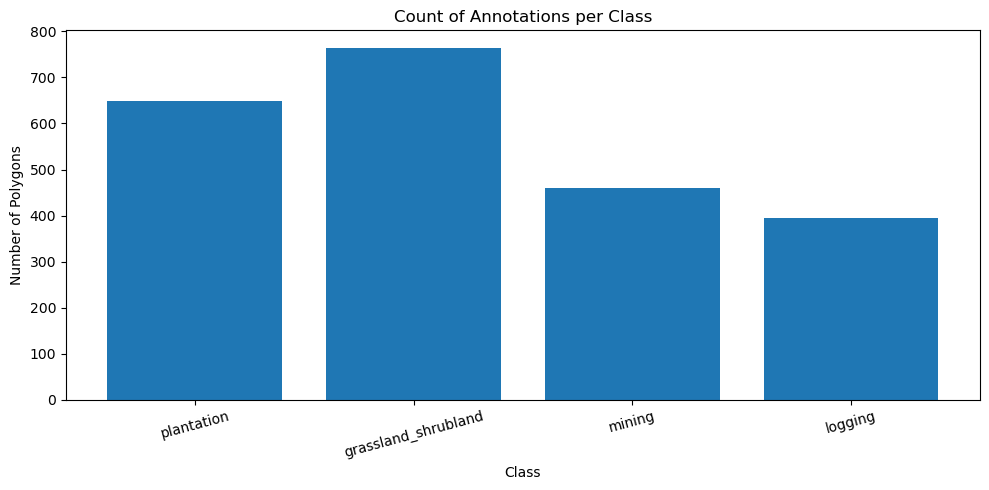

In [10]:
counts, area = count_classes()

labels = area.keys()
values = area.values()

plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xlabel("Class")
plt.ylabel("Total Area (pixels)")
plt.title("Pixel Area per Class (including background)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


labels = counts.keys()
values = counts.values()

plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xlabel("Class")
plt.ylabel("Number of Polygons")
plt.title("Count of Annotations per Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

&nbsp;

---

&nbsp;

&nbsp;
### Data preprocessing:

&nbsp;

#### Create masks for labels

##### Defining a `create_segmentation_mask()` function create segmentation masks for each of the training pictures:


In [11]:
def create_segmentation_masks(
                            image_names: list[str], 
                              class_names: list[str], 
                              output_path, 
                              mask_shape=[4, 1024, 1024]):
    
    # Loads annotations
    annotations = open_json()
    
    # Dict with filename as key and list of corresponding annotations as values
    image_ann_dict = {img["file_name"]: img["annotations"] for img in annotations["images"]}
    
    
    for file_name in tqdm(image_names, desc="Generating masks"):
        # Initializes empty mask for all classes in each image
        mask = np.zeros(mask_shape, dtype=np.uint8)

        curr_annotations = image_ann_dict[file_name]

        # Fill polygons for each class
        for class_idx, class_name in enumerate(class_names): #Skips background class
            class_annotations = [ann for ann in curr_annotations if ann["class"] == class_name]
            polygons = [ann["segmentation"] for ann in class_annotations]
        
        # Draw each polygon on the corresponding class channel
            for poly in polygons:
                points = np.array(poly).astype(np.int32).reshape(-1, 2)
                cv2.fillPoly(mask[class_idx], [points], 1)

        driver_masks_combined = np.clip(mask[:4].sum(axis=0), 0, 1)
        

        # Save the mask as a .npy file
        np.save(output_path + file_name.replace(".tif", ".npy"), mask)

    print(f"Masks saved in {output_path}")

&nbsp;

**Utilizing** `create_segmentation_masks()` **and save corresponding masks in** `/masks/` **folder:**

In [12]:
image_names = [f"train_{i}.tif" for i in range(176)]
class_names = ["plantation", "mining", "logging", "grassland_shrubland"]

create_segmentation_masks(image_names, class_names, data_path + "/masks/")

Generating masks: 100%|██████████| 176/176 [00:01<00:00, 154.58it/s]

Masks saved in data/masks/


&nbsp;

#### Looking at the newly created mask

**Furthermore we define** `visualize_npy_channels()` **function to visualize the newly created masks:**

In [13]:
def visualize_npy_channels(file_path, class_names=class_names):
    data = np.load(file_path)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid
    fig.suptitle("Channels Visualization", fontsize=16)

    for i in range(4):
        ax = axes[i // 2, i % 2]  # Determine position in 2x2 grid
        ax.set_title(f"{class_names[i]}")
        im = ax.imshow(data[i], cmap='viridis')  # Plot each channel
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar to each subplot
        ax.set_xlabel("Width")
        ax.set_ylabel("Height")

    # Adjust layout and display
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    plt.show()

&nbsp;

**Utilizing the** `visualize_npy_channels()` **function:**

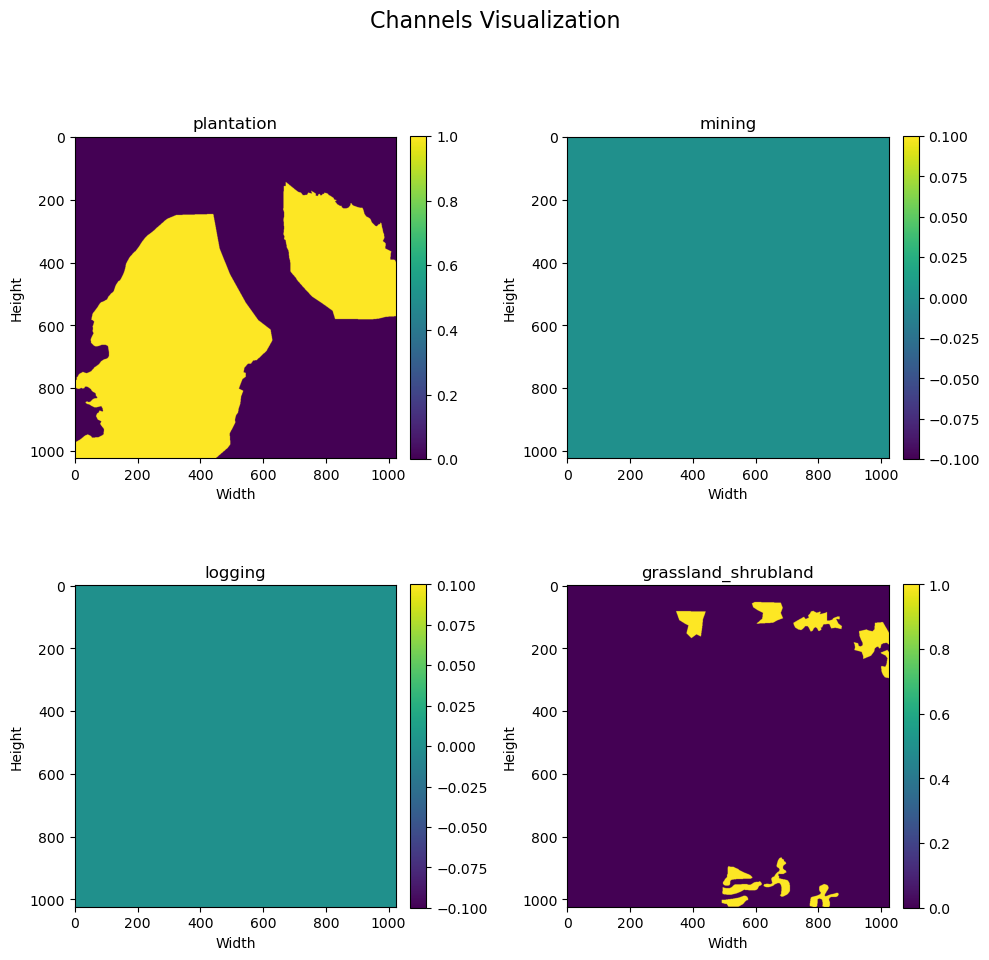

In [14]:
# Example usage
visualize_npy_channels("./data/masks/train_107.npy")

&nbsp;

&nbsp;

#### Datasets:

**Now we define a** `torch.utils.data.Dataset` **class called** `TrainingDataset`. **This class is going to function as the main dataset for loading both images and masks when conducting training.**

In [15]:
def load_mask(mask_path):
    mask = np.load(mask_path)  # (5, H, W), uint8
    assert mask.shape == (4, 1024, 1024)
    mask = mask.transpose(1, 2, 0)  # (H, W, 4) for augmentation
    return mask.astype(np.float32)  # normalize to [0, 1]


def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read() # Shape: (C, H, W)
    
    assert image.shape == (12, 1024, 1024)
    image = np.nan_to_num(image, nan=0)

    image = image.transpose(1, 2, 0) # (H, W, 4) for augmentation
    return image.astype(np.float32)

def normalize_image(image, mean=overall_means, std = overall_stds, bands = None):
    mean = mean.reshape(12, 1, 1)
    std = std.reshape(12, 1, 1)

    if bands is not None:
        mean = mean[bands, :, :]
        std = std[bands, :, :]


    return (image - mean) / std


class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, sample_indices, augmentations=None, band_indices=None):
        self.image_paths = [Path(data_root) / "train_images" / f"train_{i}.tif" for i in sample_indices]
        self.mask_paths = [Path(data_root) / "masks" / f"train_{i}.npy" for i in sample_indices]
        self.augmentations = augmentations
        self.band_indices = band_indices
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])  # Load actual image
        mask = load_mask(self.mask_paths[idx])  # Load actual mask

        # Apply augmentations if provided
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        if self.band_indices is not None:
            image = image[:, :, self.band_indices]
            
        # Convert (H, W, C) -> (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        # Normalize
        image = normalize_image(image, bands=self.band_indices)

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask  # No more string paths

&nbsp;

---

&nbsp;

&nbsp;

### Model selection:

&nbsp;

#### Models:

&nbsp;

**In our model selection stage we start of by defining different Neural Network architectures for segmenting images.**

&nbsp;

**Defining UNet utilizing** `smp`:

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=4):
        super(UNet, self).__init__()

        self.model = smp.create_model(
            arch="unet", 
            in_channels=in_channels,
            classes=out_channels,
        )
  
    def forward(self, x):
        return self.model(x)
    
    def __str__(self):
        return "UNet"

&nbsp;

**Defining FPNNet utilizing** `smp`:

In [17]:
class FPNNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=4):
        super(FPNNet, self).__init__()

        self.model = smp.create_model(
            arch="fpn", 
            in_channels=in_channels,
            classes=out_channels,
        )
  
    def forward(self, x):
        return self.model(x)
        
    def __str__(self):
        return "FPNet"

&nbsp;

**Defining DeepNet utilizing** `smp`:

In [18]:
class DeepNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=4):
        super(DeepNet, self).__init__()

        self.model = smp.create_model(
            arch="deeplabv3", 
            in_channels=in_channels,
            classes=out_channels,
        )
  
    def forward(self, x):
        return self.model(x)

    def __str__(self):
        return "DeepNet"

&nbsp;

#### Loss functions:

&nbsp;

**Furthermore we define loss functions appropriate for the task at hand:**

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode=smp.losses.MULTILABEL_MODE, from_logits=True)
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        bce = self.bce_loss(y_pred, y_true)
        return 0.7 * dice + 0.3 * bce

&nbsp;

#### Training loop:

&nbsp;

**Furthermore we define training loops to train our models:** In this section we define `plot_loss_curve()`, `clear_cache()` and `train_model()`. The first of the three functions by plotting the respective loss curve of the list of train and val losses it retrieves. The second clears the cache of the specified device and lastly the main training loop for the model. 

In [20]:
def plot_loss_curve(train_losses, val_losses, title="Loss Curve"):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def clear_cache():
    if device.type == "cuda":
        torch.cuda.empty_cache()
    elif device.type == "mps":
        torch.mps.empty_cache()

def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, loss_fn=DiceBCELoss()):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val = float("inf")
    training_losses = []
    validation_losses = []
    f1_scores = []

    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            masks = masks.float()
            images = torch.nan_to_num(images, nan=0.0)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            # OUTPUTS MASKS SAME FORMAT

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            del images, masks, outputs
            clear_cache()

        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)


        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)
                images = torch.nan_to_num(images, nan=0.0)
                outputs = model(images)
                val_loss += loss_fn(outputs, masks).item()

                

                del images, masks, outputs
                clear_cache()

        avg_val_loss = val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val:
            best_weights = model.state_dict()
            best_val = avg_val_loss


    
    model.load_state_dict(best_weights)
    plot_loss_curve(training_losses, validation_losses)
    return best_val

&nbsp;

**Initializing variables and conducting training:**

In [21]:
batch_size=2

train_indices = list(range(0, 140))
val_indices = list(range(140, 176))

###############################################################
#Models trained with specific bands
cwd = os.getcwd()
json_folder = os.path.join(cwd, 'BandSelec_impl')
json_file_bands = os.path.join(json_folder, 'best_bands.json')
best_bands = open_json(file_path=json_file_bands)
###############################################################

#train_dataset = TrainingDataset(data_path, train_indices, augmentations=None)
#val_dataset = TrainingDataset(data_path, val_indices)

##########################################################################################
train_dataset_w_bands = TrainingDataset(data_path, train_indices, augmentations=None, band_indices=best_bands)
val_dataset_w_bands = TrainingDataset(data_path, val_indices, band_indices=best_bands)
##########################################################################################

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

###################################################################################################
train_loader_w_bands = DataLoader(train_dataset_w_bands, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_w_bands = DataLoader(val_dataset_w_bands, batch_size=1, shuffle=True, num_workers=0)
###################################################################################################

#model1 = UNet()
#model2 = FPNNet()
#model3 = DeepNet()

######################################################
model1 = UNet(in_channels=len(best_bands))
model2 = FPNNet(in_channels=len(best_bands))
model3 = DeepNet(in_channels=len(best_bands))
#######################################################

models = [model1, model2, model3]
model_loss = [0, 0, 0]



train = True
for i in range(0, len(models)):
    model = models[i]
    if train:
        print(f"Training model {model}")
        best_loss = train_model(model, train_loader_w_bands, val_loader_w_bands, num_epochs=10)
        model_loss[i] = best_loss
        torch.save(model.state_dict(), f"{model}_weights.pth")
    else:
        print("Load pretrained weights")
        model.load_state_dict(torch.load(f"{model}_weights.pth"))



best_index = model_loss.index(min(model_loss))
best_model = models[best_index]
print(best_model)

Training model UNet


Epoch 1/10:  51%|█████▏    | 36/70 [12:35<11:53, 21.00s/it]


KeyboardInterrupt: 

&nbsp;

Now, after retrieving the best model we move on to visualize some of the predictions of the best chosen model on the validation set.

**Defining** `visualize_random_predictions()`:

In [ ]:
def visualize_random_predictions(model, data_loader, device, num_images):
    model.eval()  # Set model to eval mode
    indices = random.sample(range(len(data_loader.dataset)), num_images)  # Pick random indices

    with torch.no_grad():
        for idx in indices:
            # Get one image & mask from dataset
            image, mask = data_loader.dataset[idx]  # Assuming dataset implements __getitem__()
            

            image = image.to(device).unsqueeze(0) 
            mask = mask.to(device)  # Shape: (4, H, W)
            

            # Get model prediction
            #predicted_mask = model(image)  # Shape: (1, 4, 1024, 1024)
            #predicted_mask = predicted_mask.squeeze(0).cpu().numpy()  # Remove batch dim -> (4, 1024, 1024)
            # Get model prediction
            logits = model(image)
            probs = torch.sigmoid(logits)
            predicted_mask = (probs > 0.5).float().squeeze(0).cpu().numpy()
            

            mask = mask.cpu().numpy()
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns
            class_names = ["Class 1", "Class 2", "Class 3", "Class 4"]  # Adjust as needed

            for class_idx in range(4):  # Iterate over each class
                # True Mask (Top Row)
                axes[0, class_idx].imshow(mask[class_idx], cmap='gray')  
                axes[0, class_idx].set_title(f'True Mask (Class {class_idx})')
                axes[0, class_idx].axis('off')
                

                # Predicted Mask (Bottom Row)
                axes[1, class_idx].imshow(predicted_mask[class_idx], cmap='gray', vmin=0, vmax=1)
  
                axes[1, class_idx].set_title(f'Predicted Mask (Class {class_idx})')
                axes[1, class_idx].axis('off')

            plt.show()

&nbsp;

**Utilizing the function on the validation set making the best model predict on** `num_images` **number of images:**

In [ ]:
visualize_random_predictions(best_model, val_loader_w_bands, device, num_images=3)

&nbsp;

---

&nbsp;

&nbsp;

### Model evaluation:

&nbsp;

#### Test set:
Furthermore for evaluating the chosen model on the test set we use Solafunes (the competition owner) own evaluation method via submitting the inferred predictions to the website. Thus, the test set only needs to retrieve the images and not corresponding masks.

&nbsp;

**Defining** `TestDataset`:

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, sample_indices):
        self.image_paths = [Path(data_root) / "evaluation_images" / f"evaluation_{i}.tif" 
                            for i in sample_indices]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = load_image(image_path)  # Load actual image
        
        # Convert (H, W, C) -> (C, H, W)
        image = image.transpose(2, 0, 1)

        # Normalize
        image = normalize_image(image)

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)

        # file name as string for the submission file
        file_name = image_path.name
        
        return {"image": image, "image_path": file_name}


# for handling non-tensor objects when stacking samples into batches
def collate_fn(batch):
    return {
        "image": torch.stack([b["image"] for b in batch]),
        "image_path": [b["image_path"] for b in batch]
    }

&nbsp;

**Defining Inference logic** `make_predictions`:

In [ ]:
def make_predictions(model, loader, output_dir):
    # convert to path object
    output_dir = Path(output_dir)
    # make dir if needed
    output_dir.mkdir(exist_ok=True, parents=True)
    # set model to eval 
    model.eval().to(device)
    
    
    for batch in tqdm(loader, desc="Predicting"):
        image = batch["image"].to(device)
        
        with torch.no_grad():
            # get prediction
            logits = model(image)
            probs = torch.sigmoid(logits).cpu().numpy()

        for name, p in zip(batch["image_path"], probs):
            np.save(output_dir / name.replace(".tif", ".npy"),
                    p.astype(np.float16))


&nbsp;

**Defining submission functions:** As we are submitting the inferred labels to Solafunes evaluation tool, we need to make functions making the inferred data ready for passing to evaluation tool. As explained before Solafune uses a specific `.json`  formatting, thus, we need to match this formatting.

In [ ]:
# Polygon Conversion
def mask_to_polygons(mask):
    '''Convert a binary mask to polygon segmentations'''
    mask = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    for contour in contours:
        if contour.shape[0] >= 3:
            polygon = contour.squeeze().flatten()
            if len(polygon) >= 6:
                polygons.append([int(p) for p in polygon])
    return polygons


def generate_annotations_for_image(file_name, mask, class_names):
    '''Generate annotations per class from predicted mask'''
    annotations = []
    for class_idx, class_name in enumerate(class_names):
        class_mask = mask[class_idx]
        for polygon in mask_to_polygons(class_mask):
            annotations.append({
                "class": class_name,
                "segmentation": polygon
            })
    return {"file_name": file_name, 
            "annotations": annotations} 


def npy_to_submission(pred_dir, out_json,
                    score_thresh=0.5, min_area=10):
    class_names = ["plantation","mining",
                   "logging","grassland_shrubland"]
    images = []

    for npy_path in sorted(Path(pred_dir).glob("*.npy")):
        probs = np.load(npy_path)                # (4,H,W)
        binary = (probs > score_thresh).astype(np.uint8)

        # optional tiny-area filter
        for ci in range(4):
            if binary[ci].sum() < min_area:
                binary[ci][:] = 0

        images.append(
            generate_annotations_for_image(
                file_name = npy_path.stem + ".tif",
                mask      = binary,
                class_names=class_names)
        )

    with open(out_json,"w",encoding="utf-8") as fp:
        json.dump({"images": images}, fp, indent=4)
    print(f"Submission saved -> {out_json}")


&nbsp;

**And lastly, making predictions on the test set with the best performing model** `best_model`:

In [ ]:
model = best_model

test_indices = list(range(0, 118))
pred_dir = data_path + "predictions_unet"
submission_out = data_path + "submission.json"

test_dataset = TestDataset(data_path, test_indices)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

make_predictions(model, test_loader, pred_dir) 
npy_to_submission(pred_dir, submission_out, 0.5, 10)